# EDA with Apache Spark

In [2]:
import pyspark as ps
import random

spark = ps.sql.SparkSession.builder \
        .appName("rdd test") \
        .getOrCreate()

random.seed(1)

In [3]:
# Test spark using the following code..
def sample(p):
    x, y = random.random(), random.random()
    return 1 if x*x + y*y < 1 else 0

count = spark.sparkContext.parallelize(range(0, 10000000)).map(sample) \
             .reduce(lambda a, b: a + b)

print("Pi is (very) roughly {}".format(4.0 * count / 10000000))

Pi is (very) roughly 3.14217


In this notebook, I will try to explore the data I'm using to build the activities recommender. Before I go too far with the analysis, let me explain what the data is and where it is from.

# Strava:

Strava is an activity tracker and athlete social network. It is available in mobile and web application formats. It is also available to apple watches as an addon to the standalone mobile app. Strava recently released a new feature called athlete posts which allows athlete's to update their social feeds with blog style postings on their adventures. Strava describes it's new goal as, "everything you love about your sport, in one app".

## Activities:

Activities in Strava are the main item's that User's get to post through the app. There are many activities you can do but for the purpose of my app, I will be focusing on just rides(cycling) and runs.

## Objective:

The main objective of this notebook is to explore the strava data, make some inferences about the activities and build a recommender model that will analyze and incoming user's previous strava data and output customized recommendations for activities. This model will be integrated with a Django web application for tracking and managing an athlete's recommendations online.

To start I will import the necessary modules:

In [4]:
import numpy as np # linear algebra
import pandas as pd # Data ETL, csv file I/O
import matplotlib.pyplot as plt # MATLAB like plotting framework
import seaborn as sns # statistical data vizualization library based on matplotlib

color = sns.color_palette()

%matplotlib inline

In [5]:
from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf-8"))

act_ids_135209.csv
act_ids_89358.csv
activities_large.csv
activities_small.csv
ath_ids_1745.csv
athletes_small.csv
athletes_small.pkl
colorado_cities.csv
item_similarity_rides.npy
item_similarity_runs.npy
remaining_acts.csv
rides_clusterer.pkl
rides_mapper.pkl
runs_clusterer.pkl
runs_mapper.pkl
user_similarity_rides.npy
user_similarity_runs.npy



The above are files I have used to store data that I used in the building of the web application and recommender model. The files beginning with "act_id" contain activity id's I initially scraped using the [web scraping class]('../scrape_clean/scraper.py'). activities_large.csv and activities_small.csv contain rows of activity data and as indicated by them name the size is small and large: small for building and testing the model, large for actually training the production model.

ath_ids_1745.csv contains 1745 athlete id's from who's accounts I was planning to pull most of the data. This didn't work the way I initially intended as the Strava v3 API requires you to have the id associated with each activity in order to pull the data and the API doesn't allow you to query for activity id's simply given the athlete id. athletes_small.csv is file with profile data for a set of athlete's. This will not be used in the production app.

colorado_cities.csv contains a list of colorado cities and latitude/longitutde data for each that I scraped using [get_cities_wikipedia.py]('../scrape_clean/get_cities_wikipedia.py'). The rest of the files are artifacts from the previous iteration of this project (TODO: archive these files).

let's go ahead and take a look at the activities data:

In [6]:
small_df = pd.read_csv("../data/activities_small.csv", parse_dates=["start_date", "start_date_local"])
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9925 entries, 0 to 9924
Data columns (total 40 columns):
id                        9925 non-null int64
name                      9924 non-null object
distance                  9925 non-null float64
moving_time               9925 non-null float64
elapsed_time              9925 non-null float64
total_elevation_gain      9925 non-null float64
type                      9925 non-null object
start_date                9925 non-null datetime64[ns]
start_date_local          9925 non-null datetime64[ns]
timezone                  9925 non-null object
achievement_count         9925 non-null int64
kudos_count               9925 non-null int64
comment_count             9925 non-null int64
athlete_count             9925 non-null int64
photo_count               9925 non-null int64
total_photo_count         9925 non-null int64
trainer                   9925 non-null bool
commute                   9925 non-null bool
manual                    9925 non-nul

In [7]:
large_df = pd.read_csv("../data/activities_large.csv", parse_dates=["start_date", "start_date_local"])
large_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105487 entries, 0 to 105486
Data columns (total 40 columns):
id                        105487 non-null int64
name                      105477 non-null object
distance                  105487 non-null float64
moving_time               105487 non-null float64
elapsed_time              105487 non-null float64
total_elevation_gain      105487 non-null float64
type                      105487 non-null object
start_date                105487 non-null datetime64[ns]
start_date_local          105487 non-null datetime64[ns]
timezone                  105487 non-null object
achievement_count         105487 non-null int64
kudos_count               105487 non-null int64
comment_count             105487 non-null int64
athlete_count             105487 non-null int64
photo_count               105487 non-null int64
total_photo_count         105487 non-null int64
trainer                   105487 non-null bool
commute                   105487 non-null boo

Full disclosure, this is not actually the raw data format I recieved from the Strava v3 API. I already ran this data through transformer functions located in [get_cities_wikipedia.py]('../scrape_clean/setup.py'). These did things such converting data-types, parsing object types such as map and athlete for useful information and adding a state and closest city column.

I have already taken a look at some of the distributions from the data above in the notebook [eda_modeling.ipynb]('./eda_modeling.ipynb'). The above data is great but the spark ALS recommender model, uses data in the format:

`user_id, item_id, rating (optional: date of last rating)`

## Clustering

In order to get a ratings data to look at, I will need to run it through a custom clustering model which clusters by geographical location using latitude, longitude and google summary_polyline format. Let's see how this works. First I will create a dataframe on which to predict clusters.

In [26]:
df = small_df[small_df['commute'] == 0] # drop all where commute = true and store as new dataframe, df
df = df[df['state'] == 'Colorado'] # drop all where state != Colorado
df = df[df['type'] == 'Ride'] # drop everything that is not of type 'Ride' for now
df.dropna(subset=['map_summary_polyline'], inplace=True) # drop all where map_summary_polyline is nan

Next build training and test set. Since this is clustering, it is unsupervised, therefor there are no labels to test against. The test set is simply to test the transform method on held out or new data.

In [9]:
msk = np.random.rand(len(df)) < 0.75
train = df[msk].reset_index(drop=True)
test = df[~msk].reset_index(drop=True)

Next start the clusterer, fit it on training data, predict labels for the training set, then transform the test set:

In [10]:
import sys
sys.path.insert(0, '../velosparkapp/recommender/')
from clustering import PolyClusterer

clusterer = PolyClusterer()
clusterer.fit(train)
train_labels = clusterer.predict(train)
test_labels = clusterer.transform(test)

In [16]:
df.shape[0] == train_labels.shape[0] + test_labels.shape[0]

True

So we know the clustering outputs activity labels for all the activities. Under the covers, it actually appends the labels on to dataframe for the training set. It does not, however, do this to the test set. Another thing it will do is yield a dataframe of clusters centers.

In [23]:
centroids = clusterer.cluster_centers_
centroids

,activity_id,end_lat,end_lng,index,map_summary_polyline,start_lat,start_lng
0,25b96643,39.98,-105.07,4.0,_t_sFf|h`SXmIqBQjB^BdFZsNpGcN_HdOm@jPbp@}@ap@~...,39.98,-105.07
1,634541b3,40.00,-105.30,5.0,opdsFxjlaSO`CaIzAq@`g@sDp@ErP_VaFq\o@eAiF}@zEw...,40.01,-105.25
2,3d4e6eba,39.75,-104.94,6.0,esrqFjuj_SxXJ@qFld@e@~xAA~BbDvZ`AbKeFnAzE@h^zh...,39.75,-104.92
3,96c5e064,39.40,-105.17,8.0,sjnoF|r{`S[iEeCbBwFoF~AkDyAuIk@tDgBcDaIfCtCkFq...,39.40,-105.17
4,9dbdb00c,40.12,-104.80,13.0,_s{sFnqs~Rh@c@,40.12,-104.80
5,3ac7c3ca,39.73,-105.00,29.0,ubwpFvif_SuC}vBmcCi@eHfKmq@mOoS{N{l@arAwFoYsI}...,39.61,-104.90
6,f2db8536,39.98,-105.25,44.0,e`qsF`~gbSfMtTrC~b@xPdW_b@`RcDpFBzJsYaAcHfGlFv...,40.07,-105.40
7,156d40d7,38.89,-107.00,48.0,kfjlFtiblSuM|GqCoA}GpEoEi@oBtAmDlJWfLlAzAm\nj@...,38.89,-107.00
8,4f2ea9ad,39.75,-104.99,51.0,_huqF|_s_Sn@vDbFJOtnAlhAd~AsKnOuJyN`BiDt@nAs@iB,39.76,-104.96
9,272951f4,39.70,-105.25,60.0,yfcqFvn{`S~EaE|f@yExLoKnAaG~CwCfMdS`KxGyLuKgLg...,39.67,-105.17


What these are, are simply the geographic locations of every cluster including the index column of the cluster center in the original training set. What this could be useful for is displaying locations on a map to have a user click on and see what routes are leaving from that location. Let's do some simple validation to make sure my clustering is working:

In [44]:
train[train['activity_id'] == '00c6c4b2']

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date,start_date_local,timezone,...,athlete_id,map_id,map_summary_polyline,start_lat,start_lng,end_lat,end_lng,state,closest_city,activity_id
9,131072062,04/16/2014 All I had time for,24710.8,3292.0,3292.0,676.0,Ride,2014-04-16 23:52:21,2014-04-16 17:52:21,America/Denver,...,373166,a131072062,oaqqFfjgaSjJuAiBzHf@nG{BzAyBtGaGzEFnGcHy@_AdBR...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
11,683147333,Morning Ride,21759.5,4400.0,4473.0,547.0,Ride,2016-08-18 13:15:13,2016-08-18 07:15:13,America/Denver,...,9428936,a683147333,{aqqFljgaSKfA~JsCeBhHh@hG}N`RHrGmH_Ao@jBd@bFkH...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
214,558630378,Lunch Ride,33970.7,5066.0,5553.0,912.0,Ride,2016-04-27 17:49:19,2016-04-27 11:49:19,America/Denver,...,1514935,a558630378,e_qqFtkgaS`HcCw@tP}NhRFbGuGcAw@fJaGu@gIzHtIsHv...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
315,250874039,Lunch Ride,30772.6,4966.0,5345.0,896.2,Ride,2015-02-05 19:58:14,2015-02-05 12:58:14,America/Denver,...,1412833,a250874039,e`qqFvigaSmAdAzJqCi@bQuNnQDvGkH_Ae@hJ{FcAwUvSn...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
396,735316827,pushing watts....legs feel like lead today,36283.7,6170.0,6372.0,917.0,Ride,2016-10-05 14:32:30,2016-10-05 08:32:30,America/Denver,...,1183267,a735316827,maqqFzigaSbJgAq@dPmOzStOmSb@eQiMlEjM_EsAfK|AmK...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
496,206573176,Sunday Ride,7669.4,2861.0,3832.0,347.1,Ride,2014-10-12 16:23:19,2014-10-12 10:23:19,America/Denver,...,1411091,a206573176,kwrqFnqgaSlBfKnEx@f@bGs@zBdOeA~FvCjAuAxJ`FTzAb...,39.75,-105.23,39.75,-105.23,Colorado,Golden,00c6c4b2
517,358878960,Lookout Mtn HC warm up,8135.4,1529.0,1886.0,222.0,Ride,2015-08-01 13:23:53,2015-08-01 07:23:53,America/Denver,...,55375,a358878960,acqqFflgaS_BP}KwQ{L|LAnN|OxP|Bb@~RaOa@oH`BuHyN...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
546,358879149,Lookout Mtn. Hill Climb x2,50293.3,7218.0,10139.0,1049.0,Ride,2015-08-01 13:59:59,2015-08-01 07:59:59,America/Denver,...,55375,a358879149,iypqFfigaSf@rOuN~Y_H}@i@~Ig[xL`@bf@dGsKiAaPrb@...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
614,186126776,Morning Ride,23122.4,3806.0,4152.0,677.5,Ride,2014-08-27 16:27:15,2014-08-27 10:27:15,America/Denver,...,1412833,a186126776,{bqqFligaSlACa@zA|JaDsA`FpAmFoDtAdDu@uBvIj@pFk...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
723,468981020,Morning Ride,27410.5,4123.0,4407.0,787.0,Ride,2016-01-12 17:46:13,2016-01-12 10:46:13,America/Denver,...,1514935,a468981020,_bqqFfjgaSzJ{AgB`If@nGuNlQ@lGcIUFfGE_GjIJM_G|N...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2


In [52]:
test['activity_id'] = test_labels

In [53]:
test[test['activity_id'] == '00c6c4b2']

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date,start_date_local,timezone,...,athlete_id,map_id,map_summary_polyline,start_lat,start_lng,end_lat,end_lng,state,closest_city,activity_id
103,358877240,Lookout,20247.3,2608.0,3307.0,476.0,Ride,2015-08-01 15:45:06,2015-08-01 09:45:06,America/Denver,...,2961139,a358877240,aypqFxhgaSnAc@eB|Hl@tFoN|QDtGmHw@e@|IgGu@{GzDi...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
169,226496048,1x28min. interval,24861.9,4004.0,4125.0,610.0,Ride,2014-12-05 18:24:56,2014-12-05 11:24:56,America/Denver,...,1183267,a226496048,qbqqFnjgaSzJ{AyAvHn@pFaOpRHbGiGcAuAlDdBaDrFhAJ...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
268,611063717,Morning Ride,31493.6,4397.0,4962.0,834.8,Ride,2016-06-16 13:15:55,2016-06-16 07:15:55,America/Denver,...,1412833,a611063717,s`qqFfjgaStIkAgB|RpBmSqAhRuGnJpHmLr@aQy@tQeOlR...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
285,687927172,Afternoon Ride,29389.2,4715.0,4922.0,805.0,Ride,2016-08-24 19:37:44,2016-08-24 13:37:44,America/Denver,...,1514935,a687927172,w`qqF|igaSq@x@bKgCcB`In@dFgOrRJ|FgHo@i@~IsF}@m...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
498,867708346,Wednesday Hill Climber Group,51426.4,8524.0,10098.0,1359.0,Ride,2017-02-15 17:11:53,2017-02-15 10:11:53,America/Denver,...,2638390,a867708346,gaqqFhlgaS~IqCw@`QyNrQHdGiHs@e@bJwGo@_UpSlD|Py...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
526,837562539,Lunch Ride,36615.7,5498.0,5563.0,1028.0,Ride,2017-01-19 19:43:46,2017-01-19 12:43:46,America/Denver,...,1514935,a837562539,caqqFfjgaS|IwAw@nP_OnRL|FeHq@o@bJqGo@_UlShDbQ}...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
556,551563980,Intervals w/M....heavy air,28490.3,5064.0,5396.0,749.0,Ride,2016-04-20 15:58:04,2016-04-20 09:58:04,America/Denver,...,1183267,a551563980,_bqqFrigaSpJ}@o@xPsNxPClHgHs@c@`JyOrBcMxOlDbOk...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
662,226245556,Lookout,31361.1,4455.0,4797.0,844.4,Ride,2014-12-04 19:00:31,2014-12-04 12:00:31,America/Denver,...,1514935,a226245556,{bqqF~ggaSb@tClJ{DqMjEgDqD|CfE|MsE{@xQ{NhQDnG}...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
681,412892571,Morning Ride,23793.4,3377.0,3648.0,608.8,Ride,2015-10-14 13:23:35,2015-10-14 07:23:35,America/Denver,...,1412833,a412892571,q`qqFfhgaSeDrC{NkWbOtXbNuE}AbIf@zFqNvQM|GoGcAc...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2
712,183517092,Afternoon Ride,34389.8,4209.0,4480.0,861.2,Ride,2014-08-21 19:32:15,2014-08-21 13:32:15,America/Denver,...,1412833,a183517092,_bqqFdkgaS}C?oQuZwZnXsEb`@uFlJsFbE_Lp@mIyFs\yI...,39.74,-105.23,39.74,-105.23,Colorado,Golden,00c6c4b2


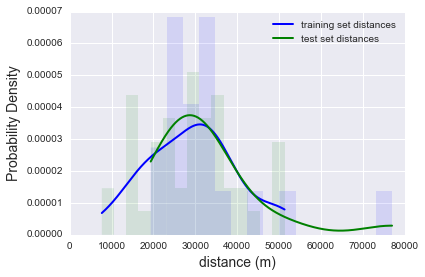

In [56]:
from scipy.stats.kde import gaussian_kde

# use activities with id 00c6c4b2
dfa = train[train['activity_id'] == '00c6c4b2']
dfb = test[test['activity_id'] == '00c6c4b2']

train_dsts = dfa['distance'].values
test_dsts = dfb['distance'].values
plt.hist(train_dsts, bins=15, alpha=.1, edgecolor='none', color='g', normed=1)
plt.hist(test_dsts, bins=15, alpha=.1, edgecolor='none', color='b', normed=1)

# Plotting the KDE of train and test
kde_pdf = gaussian_kde(train_dsts)
x = np.linspace(min(train_dsts), max(train_dsts), 1000)
y = kde_pdf(x)
plt.plot(x, y, color='b', lw=2, label='training set distances')

kde_pdf = gaussian_kde(test_dsts)
x = np.linspace(min(test_dsts), max(test_dsts), 1000)
y = kde_pdf(x)
plt.plot(x, y, color='g', lw=2, label='test set distances')
plt.ylabel('Probability Density', fontsize=14)
plt.xlabel('distance (m)', fontsize=14)

plt.legend(frameon=False)
plt.show()

Compared to training data the test data appears to have a similar distribution in the distances of the rides taken. This is good since it show that most of the activities with the same activity_id are around the same distance traveled by the athlete. Let's take a look at elevation gain:

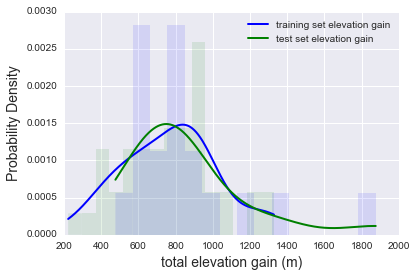

In [57]:
train_dsts = dfa['total_elevation_gain'].values
test_dsts = dfb['total_elevation_gain'].values
plt.hist(train_dsts, bins=15, alpha=.1, edgecolor='none', color='g', normed=1)
plt.hist(test_dsts, bins=15, alpha=.1, edgecolor='none', color='b', normed=1)

# Plotting the KDE of train and test
kde_pdf = gaussian_kde(train_dsts)
x = np.linspace(min(train_dsts), max(train_dsts), 1000)
y = kde_pdf(x)
plt.plot(x, y, color='b', lw=2, label='training set elevation gain')

kde_pdf = gaussian_kde(test_dsts)
x = np.linspace(min(test_dsts), max(test_dsts), 1000)
y = kde_pdf(x)
plt.plot(x, y, color='g', lw=2, label='test set elevation gain')
plt.ylabel('Probability Density', fontsize=14)
plt.xlabel('total elevation gain (m)', fontsize=14)

plt.legend(frameon=False)
plt.show()

## Ratings

Using this small dataset again, let's see if we can get the ratings for athlete's identified by their id.

In [ ]:
df = 